#  Cats vs Dogs Classification using VGG16 Transfer Learning
This notebook implements a two-stage transfer learning pipeline using VGG16 for binary image classification (Cats vs Dogs).

Install & Download Dataset from KaggleHub

In [1]:
!pip install kagglehub scikeras

import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kaggle-cat-vs-dog-dataset


Split Dataset into Train / Val / Test

In [2]:
import os
import random
import shutil
from PIL import Image

def split_and_copy_images(src_dir, base_dst, class_name, split_ratio=(0.7, 0.15, 0.15), max_images=2400):
    class_dir = os.path.join(src_dir, class_name)
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(files)

    num_total = min(len(files), max_images)
    num_train = int(split_ratio[0] * num_total)
    num_val = int(split_ratio[1] * num_total)
    num_test = num_total - num_train - num_val

    subsets = {
        'train': files[:num_train],
        'val': files[num_train:num_train+num_val],
        'test': files[num_train+num_val:num_total]
    }

    for subset, file_list in subsets.items():
        dst_dir = os.path.join(base_dst, subset, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        count = 0
        for fname in file_list:
            src_path = os.path.join(class_dir, fname)
            dst_path = os.path.join(dst_dir, fname)
            try:
                with Image.open(src_path) as img:
                    img.verify()
                shutil.copy(src_path, dst_path)
                count += 1
            except:
                continue
        print(f"Copied {count} images to {dst_dir}")

base_data_dir = "/content/small_dataset"
src_dir = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages")

split_and_copy_images(src_dir, base_data_dir, "Cat")
split_and_copy_images(src_dir, base_data_dir, "Dog")


Copied 1680 images to /content/small_dataset/train/Cat
Copied 360 images to /content/small_dataset/val/Cat
Copied 360 images to /content/small_dataset/test/Cat
Copied 1680 images to /content/small_dataset/train/Dog
Copied 360 images to /content/small_dataset/val/Dog
Copied 360 images to /content/small_dataset/test/Dog


Define ImageDataGenerators

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 3360 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


Define Model Builder Function

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

import itertools
import numpy as np
from tensorflow.keras import layers, models

def build_model(optimizer='adam', dropout_rate=0.5, num_filters=32, num_conv_layers=1, kernel_size=(3, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Optional additional conv layers on top of VGG if needed
    for _ in range(num_conv_layers):
        x = layers.Reshape((1, 1, x.shape[1]))(x)
        x = layers.Conv2D(num_filters, kernel_size, activation='relu', padding='same')(x)
        x = layers.Flatten()(x)

    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate / 2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Grid Search for Hyperparameter Tuning

In [15]:

# Define hyperparameter grid
param_grid = {
    'dropout_rate': [0.3, 0.5],
    'num_filters': [32, 64],
    'num_conv_layers': [1, 2],
    'kernel_size': [(3, 3), (5, 5)]
}

best_accuracy = 0
best_model = None
best_params = {}

for params in itertools.product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nTraining with params: {config}")

    model = build_model(
        optimizer='adam',
        dropout_rate=config['dropout_rate'],
        num_filters=config['num_filters'],
        num_conv_layers=config['num_conv_layers'],
        kernel_size=config['kernel_size']
    )

    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        verbose=1
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Validation accuracy: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_history = history
        best_model = model
        best_params = config

print("\n✅ Best hyperparameters:")
print(best_params)
print(f"🏆 Best validation accuracy: {best_accuracy:.4f}")




Training with params: {'dropout_rate': 0.5, 'num_filters': 64, 'num_conv_layers': 1, 'kernel_size': (3, 3)}
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - accuracy: 0.6135 - loss: 0.6328 - val_accuracy: 0.8444 - val_loss: 0.3689
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 275ms/step - accuracy: 0.8081 - loss: 0.4319 - val_accuracy: 0.8792 - val_loss: 0.3057
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - accuracy: 0.8496 - loss: 0.3506 - val_accuracy: 0.8819 - val_loss: 0.2880
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - accuracy: 0.8415 - loss: 0.3573 - val_accuracy: 0.8847 - val_loss: 0.2713
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.8344 - loss: 0.3588 - val_accuracy: 0.8889 - val_loss: 0.2773
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - accuracy: 0.8449 - loss: 0.3242 - val_accuracy: 0.8847 - val_loss: 0.2675
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 277ms/step - accuracy: 0.8568 - loss: 0.3342 - val_accuracy: 

Best Parameters and Evaluation on Test Set

In [16]:


# Predict on test data

test_gen.reset()
test_preds = (best_model.predict(test_gen) > 0.5).astype("int32")
test_true = test_gen.classes

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step



Test Classification Report:

              precision    recall  f1-score   support

         Cat       0.86      0.92      0.89       360
         Dog       0.91      0.86      0.88       360

    accuracy                           0.89       720
   macro avg       0.89      0.89      0.89       720
weighted avg       0.89      0.89      0.89       720



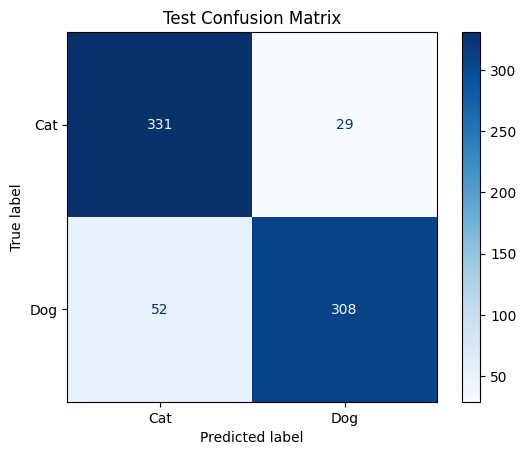

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nTest Classification Report:\n")
print(classification_report(test_true, test_preds, target_names=["Cat", "Dog"]))

cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

In [ ]:
# # Evaluation
# val_gen.reset()
# preds = (model.predict(val_gen) > 0.5).astype("int32")
# true = val_gen.classes

# # Classification Report
# print("\nClassification Report:\n")
# print(classification_report(true, preds, target_names=["Cat", "Dog"]))

# # Confusion Matrix
# cm = confusion_matrix(true, preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

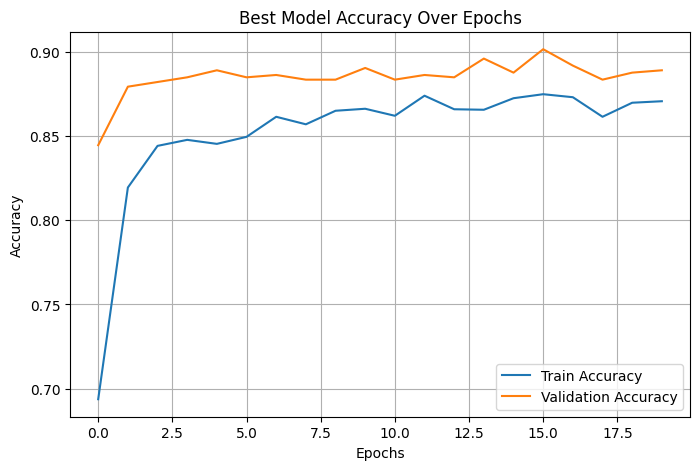

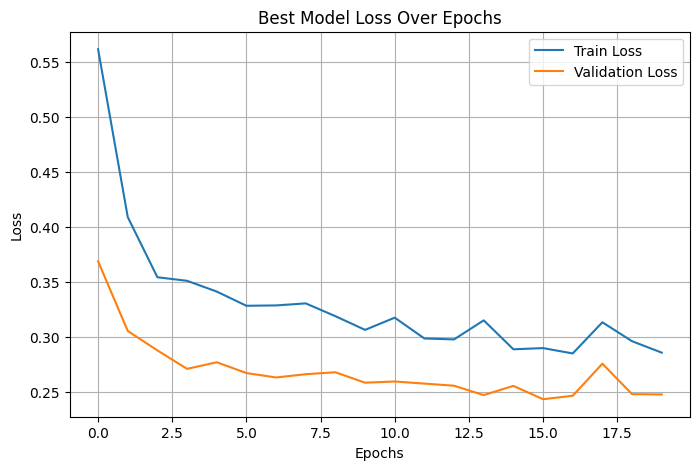

In [19]:
# Visualization


plt.figure(figsize=(8, 5))
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()